In [1]:
!pip install diffusers==0.26.3
!pip install transformers==4.38.1
!pip install accelerate==0.27.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 35.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.3
    Uninstalling transformers-4.39.3:
      Successfully uninstalled transformers-4.39.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 1.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.29.3
    Uninstalling accelerate-0.29.3:
      Successfully uninstalled accelerate-0.29.3


In [2]:
import torch
import torch as torch
import pandas as pd
import numpy as np
from kaggle_secrets import UserSecretsClient
import matplotlib.pyplot as plt
import cv2
import csv
from tqdm import tqdm

# 1- Loading and converting daata to DataFrame

In [3]:
books = []
with open("/kaggle/input/cmu-book-summary-dataset/booksummaries.txt", 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        books.append(row)
        
book_id = []
book_name = []
summary = []

for i in tqdm(books):
    book_id.append(i[0])
    book_name.append(i[2])
    summary.append(i[6])

data = pd.DataFrame({'book_id': book_id, 'book_name': book_name, 'summary': summary})

16559it [00:00, 20558.55it/s]
100%|██████████| 16559/16559 [00:00<00:00, 678627.76it/s]


# 2- EDA 

In [4]:
data.head()

book_id                                  book_name  \
0     620                                Animal Farm   
1     843                         A Clockwork Orange   
2     986                                 The Plague   
3    1756  An Enquiry Concerning Human Understanding   
4    2080                       A Fire Upon the Deep   

                                             summary  
0   Old Major, the old boar on the Manor Farm, ca...  
1   Alex, a teenager living in near-future Englan...  
2   The text of The Plague is divided into five p...  
3   The argument of the Enquiry proceeds by a ser...  
4   The novel posits that space around the Milky ...

In [5]:
import missingno as msgn

<Axes: >

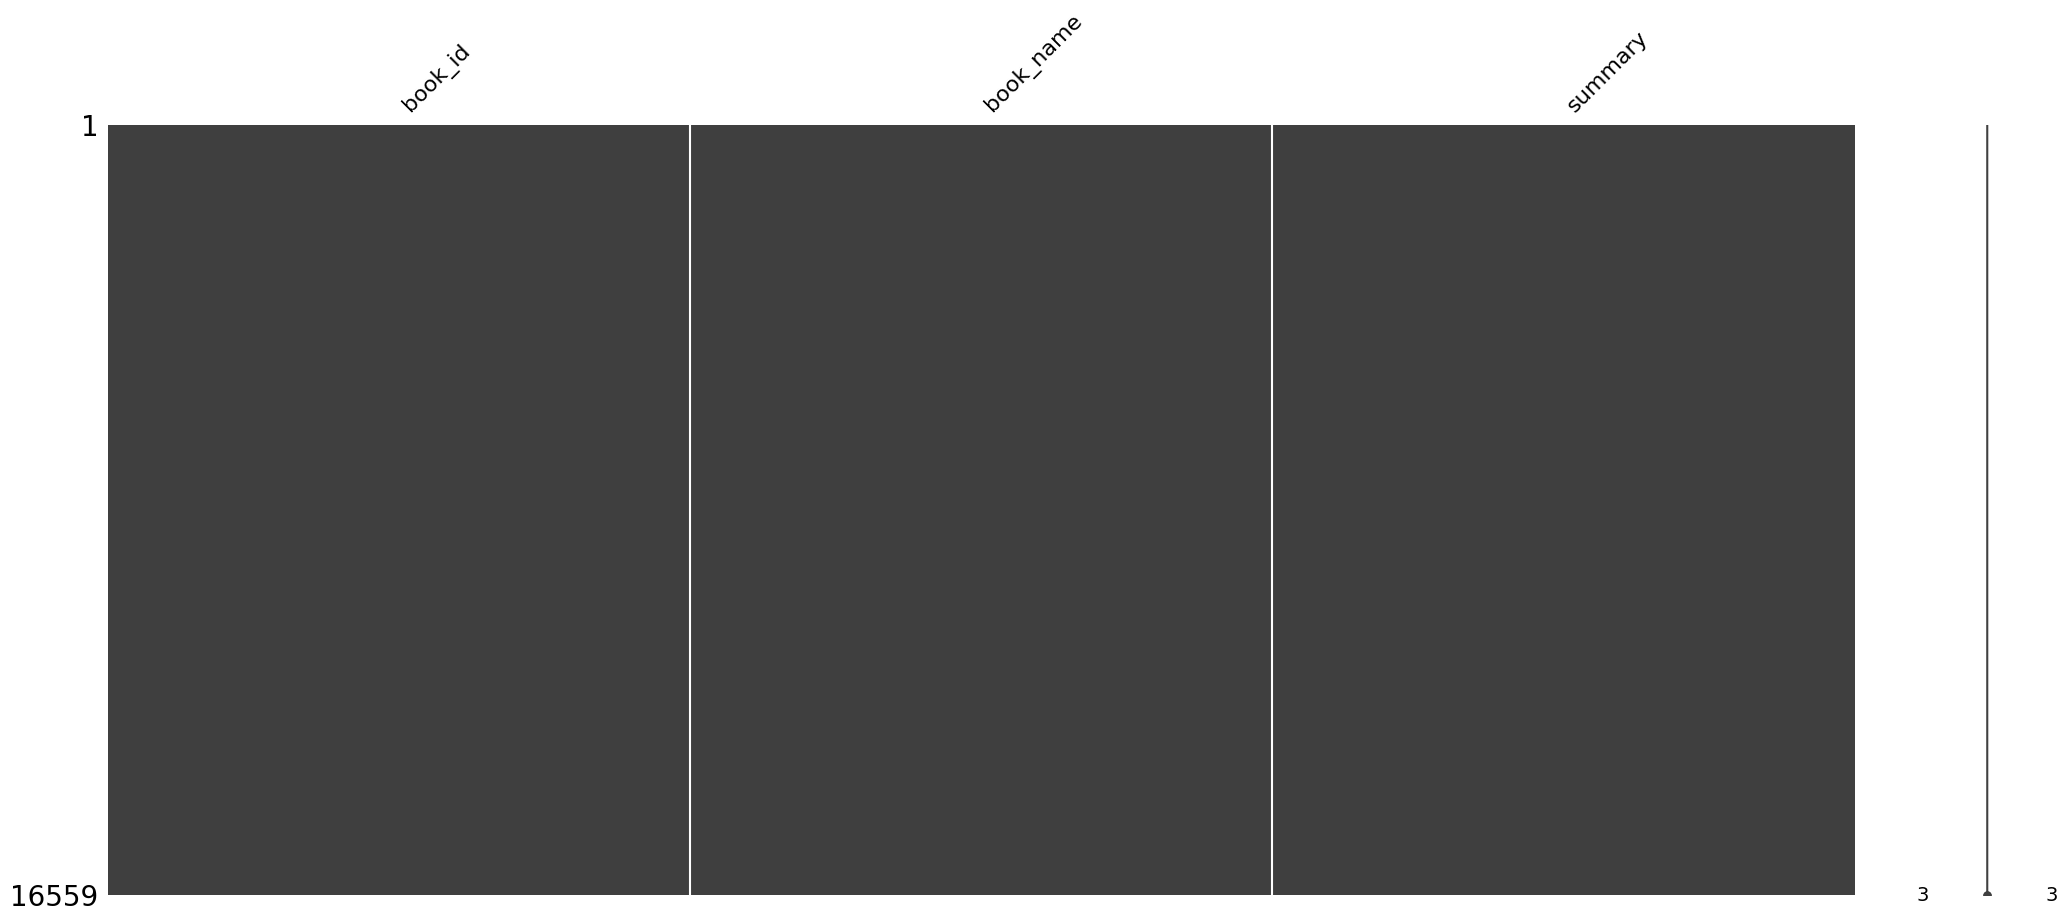

In [6]:
msgn.matrix(data)

In [7]:
print(f'avg summary length: {np.mean([len(data.summary.loc[i]) for i in range(len(data))])}')

avg summary length: 2511.1089437767982


### Text preprocessing.

In [15]:
!pip install inflect

  Using cached inflect-7.2.1-py3-none-any.whl.metadata (21 kB)
Using cached inflect-7.2.1-py3-none-any.whl (34 kB)


In [16]:
import warnings
import re
from string import punctuation
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import inflect # type: ignore

stop_words = set(stopwords.words('english'))
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'
warnings.filterwarnings('ignore')

In [17]:
contractions_dict = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"doesn’t": "does not",
"don't": "do not",
"don’t": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y’all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have",
"ain’t": "am not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"’cause": "because",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"don’t": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he had",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"i’d": "i would",
"i’d’ve": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"o’clock": "of the clock",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"so’s": "so is",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that is",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they would",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who is",
"who’ve": "who have",
"why’s": "why is",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all": "you all",
"y’all’d": "you all would",
"y’all’d’ve": "you all would have",
"y’all’re": "you all are",
"y’all’ve": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’re": "you are",
"you’ve": "you have",
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))


# Function expand the contractions if there's any
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

# Function to preprocess the articles
def preprocessing(article):
    global article_sent
    
    # Converting to lowercase
    article = article.str.lower()
    
    
    #normalize numbers
    article = article.apply(lambda x: replace_numbers_with_words(x))
    
    # Removing the contractions
    article = article.apply(lambda x: expand_contractions(x))
    
    
    
    # Removing the Trailing and leading whitespace and double spaces
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
    # Copying the article for the sentence tokenization
    article_sent = article.copy()
    
    # Removing punctuations from the article
    article = article.apply(lambda x: ''.join(word for word in x if word not in punctuation))
    
    # Removing the Trailing and leading whitespace and double spaces again as removing punctuation might
    # Lead to a white space
    article = article.apply(lambda x: re.sub(' +', ' ',x))
    
#     Removing the Stopwords (only for visualization)
    article = article.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    
    return article

def replace_numbers_with_words(text):
    p = inflect.engine()
    numbers = re.findall(r'\d+', text)
    for number in numbers:
        word_form = p.number_to_words(int(number))
        text = text.replace(number, word_form)
    return text

def make_series(art):
    global dataframe
    data_dict = {'article' : [art]}
    dataframe = pd.DataFrame(data_dict)['article']
    return dataframe

def text_summarize(artefact):
    
    summarize = []
    for sent in artefact:
        
        if type(sent) != pd.Series:
            artefact = make_series(sent)
    
        df = preprocessing(artefact)
        
        summarize.append(df[0])
        
    return summarize

In [18]:
import seaborn as sns
import string
import re
import nltk

from tqdm import tqdm
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (17,7)

### word-frequency

In [23]:
data['summary_c'] = text_summarize(data['summary'])

In [24]:
def corpus(text):
    text_list = text.split()
    return text_list

In [25]:
data['summary_list'] = data['summary_c'].apply(corpus)

In [26]:
corpus = []
for i in range(data.shape[0]):
    corpus += data['summary_list'][i]
len(corpus)

3873755

In [27]:
mostCommon = Counter(corpus).most_common(20)
mostCommon

[('one', 24465),
 ('two', 13117),
 ('time', 11498),
 ('also', 11223),
 ('new', 10408),
 ('life', 10014),
 ('back', 9695),
 ('first', 8908),
 ('book', 8637),
 ('story', 8493),
 ('find', 8219),
 ('man', 8177),
 ('however', 8175),
 ('father', 8110),
 ('hundred', 8103),
 ('family', 7573),
 ('thousand', 7362),
 ('tells', 7318),
 ('home', 7240),
 ('later', 7204)]

In [28]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

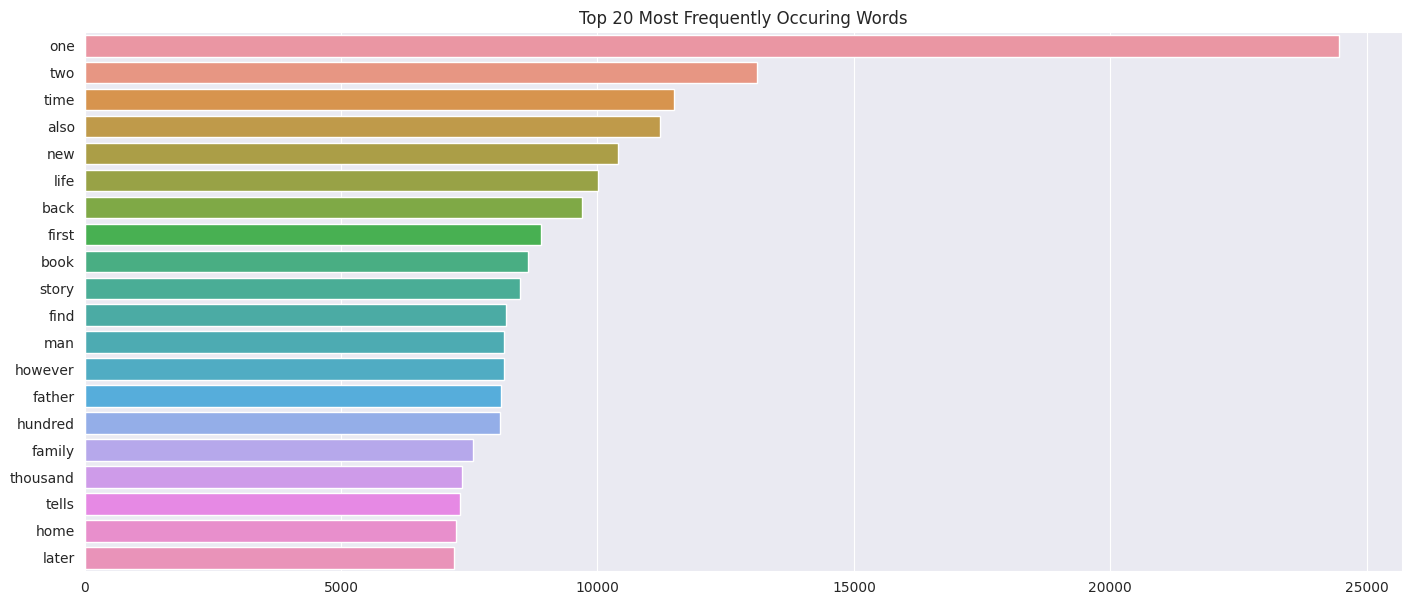

In [29]:
sns.barplot(x=freq, y=words)
plt.title('Top 20 Most Frequently Occuring Words')
plt.show()

Ignoring the numbers, the most frequent words in the dataset are 'time, new, life, story, find, family, later' which are some how `abstract` words. this is becuase of our dataset which include summary of different books,as it seems, there are many philosophical books and novels in this dataset. Therefore we need an appropriate summarizer to extract an informative and abstractive condensed text from the articles.

### N_gram analysis.

In [30]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(data['summary_c'])

In [31]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

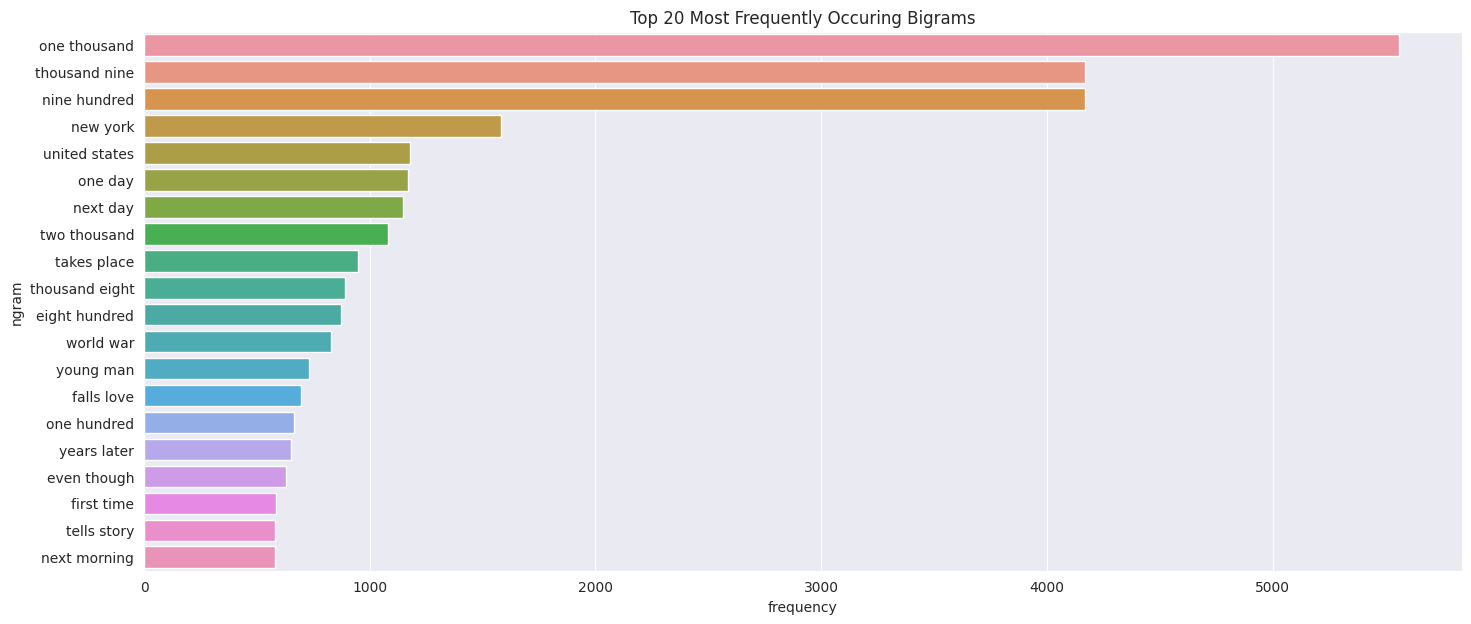

In [32]:
sns.barplot(x=ngram_freq['frequency'][:20], y=ngram_freq['ngram'][:20])
plt.title('Top 20 Most Frequently Occuring Bigrams')
plt.show()

Again by plotting the bigrams, we can see that there are lot of abstract bigrams in the articles, like 'falls love, tells story' and also lot of time dependent bigrams like 'next morning, next day' and etc. and also due to the dataset, there are much information about countries and history and different culture. So it might be challenging for the text model to generate well-informed condensed texts.

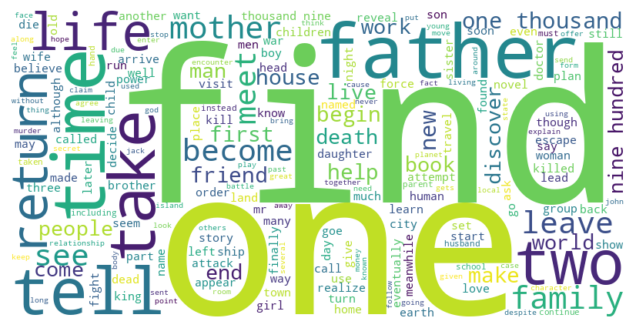

In [33]:
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(data['summary_c']))

# Display the word cloud using matplotlib
plt.figure(figsize = (8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

and also it is `word cloud` plot of the words. Most repeated cotexts in the book summaries are related to subjects like: 
Finding, returning, telling, time, becoming, family, arrive, decide, escaping, helping, killing and etc.
which are high-level abstraction! Because many emotions are hidden among these concepts and understanding them may be difficult for our language model.

# 3- Loading NLP model.

Due to the result and findings in `EDA` part, we can conclude that the appropriate model for this task, is a model which can perform well on the `Abstract` data and generate informative summaries that covers the a big-picture of the whole text. There are some options that we can test: 

- using a model which specificly trained on the similar abstract datasets for abstract summarizing like `T5`, `PEGASUS` which are powefull models introduced by `Google`. T5 model Pros are flexibility and highly-costumizeable, and suitable for extractive and abstractive teext summarization. PEGASUS is combination of seq2seq and denoising autoencoder technique to generate high-quality summaizes. `BART` is also a denoising-autoencoder based model which can generate concise and informative summarizes.

- second option is using an`LLM` like LLAMA-3, Claude, GPT-4 and other powerfull models to make a summary. which is a quiet costy way and we dont have enough resurce to handle it! 

## 3-1- T5 model.

In [34]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

In [35]:
model_name = "t5-large"  
tokenizer = T5Tokenizer.from_pretrained(model_name, legacy = False)
model = T5ForConditionalGeneration.from_pretrained(model_name)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### generate sample summary.

In [ ]:
# Prepare input text
input_text = data['summary_n'].loc[0]
input_ids = tokenizer.encode(f'summarize: {input_text}', return_tensors="pt")

# Generate summary
summary_ids = model.generate(input_ids, max_new_tokens = 50)

# Decode and print the generated summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:", summary)

# PEGASUS(Google)

In [36]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

In [37]:
model_name = "google/pegasus-xsum"
tokenizer_p = PegasusTokenizer.from_pretrained(model_name)
model_p = PegasusForConditionalGeneration.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

In [ ]:
# Prepare input text
input_text = data['summary_n'].loc[0]
input_ids = tokenizer_p.encode(input_text, max_length = 512, truncation = True, return_tensors="pt")

# Generate summary
summary_ids = model_p.generate(input_ids, max_new_tokens = 50)

summary = tokenizer_p.decode(summary_ids[0], skip_special_tokens=True)
print("Generated Summary:", summary)

In [50]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3186a26cde1db0b894cbe54aadf32ff304697954072a64507b43c16daea6744d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [51]:
from rouge_score import rouge_scorer
import random

In [58]:
def compare_modelrouge(model1, tokenizer1, model2, tokenizer2, samples):
    summ = text_summarize(samples)
    
    rouge_scores1, rouge_scores2 =[], []
    summary1, summary2 = [], []
    for sent in summ:
        # model 1
        input_ids = tokenizer1.encode(f'summarize: {sent}', return_tensors="pt")
        summary_ids = model1.generate(input_ids, max_new_tokens = 50)
        summary = tokenizer1.decode(summary_ids[0], skip_special_tokens=True)
        summary1.append(summary)
        # model 2
        input_ids = tokenizer2.encode(f'summarize: {sent}', max_length = 512, return_tensors="pt")
        summary_ids = model2.generate(input_ids, max_new_tokens = 50)
        summary = tokenizer2.decode(summary_ids[0], skip_special_tokens=True)
        summary2.append(summary)
        
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    rouge_scores1.append([scorer.score(summary1[i], summ[i]) for i in range(len(summary1))])
    rouge_scores2.append([scorer.score(summary2[i], summ[i]) for i in range(len(summary2))])
    
    return rouge_scores1, rouge_scores2
        

In [66]:
selected = [random.choice(data['summary']) for i in range(10)]
scores1, scores2 = compare_modelrouge(model, tokenizer, model_p, tokenizer_p, selected)

Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.


In [71]:
print(f'T5 result: {scores1}\nPEGASUS result{scores2}')

T5 result: [[{'rouge1': Score(precision=0.21518987341772153, recall=1.0, fmeasure=0.3541666666666667), 'rougeL': Score(precision=0.21518987341772153, recall=1.0, fmeasure=0.3541666666666667)}, {'rouge1': Score(precision=0.11965811965811966, recall=0.9333333333333333, fmeasure=0.21212121212121213), 'rougeL': Score(precision=0.11965811965811966, recall=0.9333333333333333, fmeasure=0.21212121212121213)}, {'rouge1': Score(precision=0.055674518201284794, recall=0.9285714285714286, fmeasure=0.10505050505050505), 'rougeL': Score(precision=0.055674518201284794, recall=0.9285714285714286, fmeasure=0.10505050505050505)}, {'rouge1': Score(precision=0.2028985507246377, recall=0.42424242424242425, fmeasure=0.2745098039215686), 'rougeL': Score(precision=0.17391304347826086, recall=0.36363636363636365, fmeasure=0.2352941176470588)}, {'rouge1': Score(precision=1.0, recall=0.6363636363636364, fmeasure=0.7777777777777778), 'rougeL': Score(precision=1.0, recall=0.6363636363636364, fmeasure=0.777777777777

as we can see, the performance if the T5 model is better than PEGASUS.(as we expected).

# text-to-image model.

In [72]:
from diffusers import DiffusionPipeline

In [ ]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

In [75]:
class CFG:
    device = "cuda"
    seed = 42
    generator = torch.Generator(device).manual_seed(seed)
    image_gen_steps = 50
    image_gen_size = (400,400)
    image_gen_guidance_scale = 7
    prompt_max_length = 12

In [76]:
def generate_image(prompt, model):
    image = model(
        prompt, num_inference_steps=CFG.image_gen_steps,
        generator=CFG.generator,
        guidance_scale=CFG.image_gen_guidance_scale
    ).images[0]
    
    image = image.resize(CFG.image_gen_size)
    return image

In [81]:
def generate_output(tokenizer, txt_model, img_model, data):
    summarizes = data['summary']
    
    selected = [random.choice(summarizes) for i in range(5)]
    
    selected_n = text_summarize(selected)
    
    outputs = []
    
    for i, sent in enumerate(selected_n):

        input_ids = tokenizer.encode(f'summarize: {sent}', return_tensors="pt")
        # generate summary.
        summary_ids = txt_model.generate(input_ids, max_new_tokens = 50, early_stopping = True)
        cons = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        
        # generate image.
        img = generate_image(cons, img_model)
        
        out = {
            "original text": selected[i],
            "condensed text": cons,
            "generated image": img
        }
        outputs.append(out)
        
    return outputs
        

In [82]:
outputs = generate_output(tokenizer, model, pipe, data)

Keyword arguments {'add_special_tokens': False} not recognized.


  0%|          | 0/50 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.


  0%|          | 0/50 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.


  0%|          | 0/50 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.


  0%|          | 0/50 [00:00<?, ?it/s]

Keyword arguments {'add_special_tokens': False} not recognized.


  0%|          | 0/50 [00:00<?, ?it/s]

In [83]:
def plot_image(outputs):
    
    fig, axes = plt.subplots(1, len(outputs), figsize=(50, 10))
    for i, out in enumerate(outputs):
        img = out.get('generated image')
        
        axes[i].imshow(img)
        axes[i].set_title(f'image {i + 1}')
        axes[i].axis('off')  # Turn off axis
    plt.show()

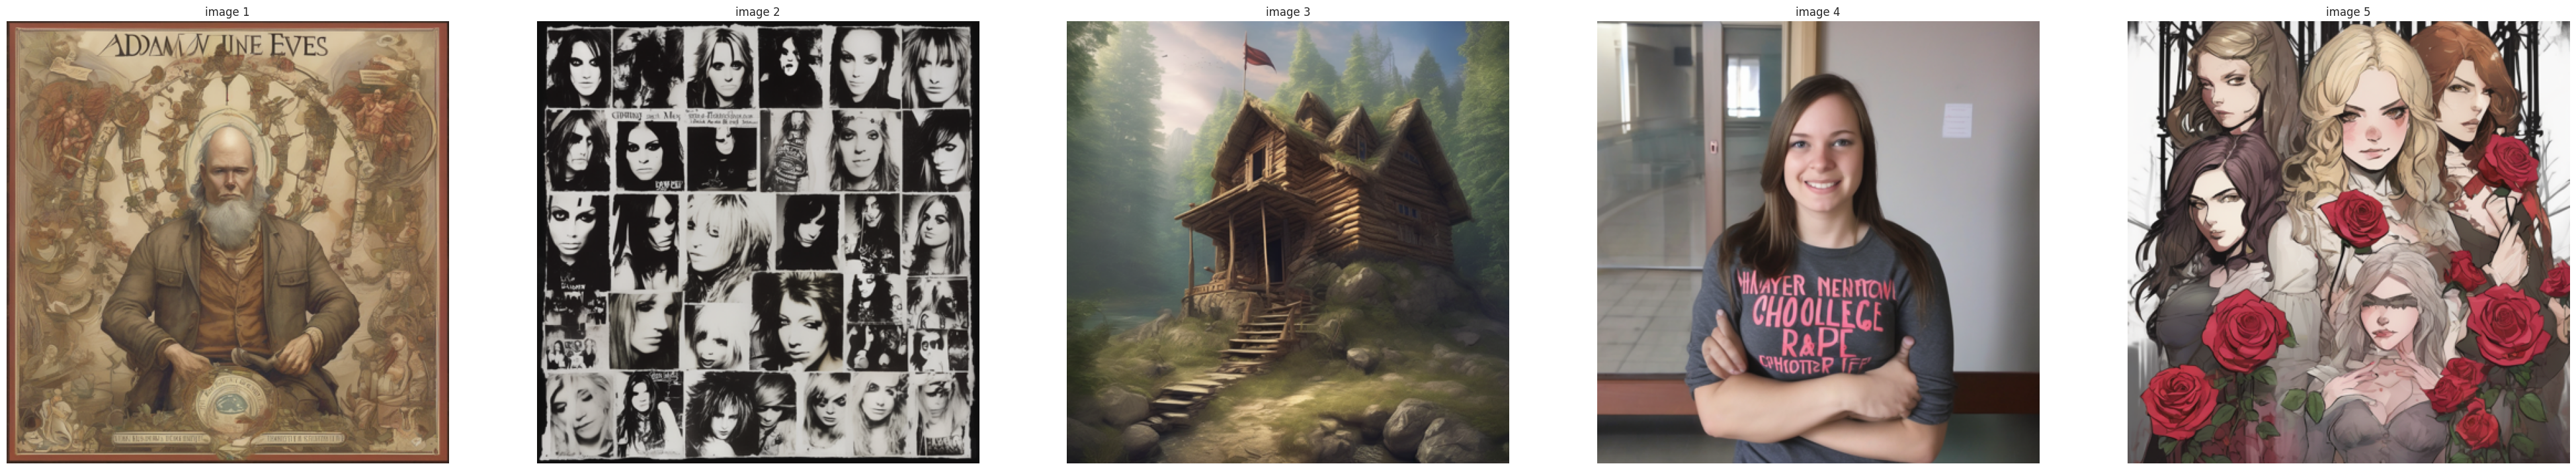

In [84]:
plot_image(outputs)

In [85]:
for i, out in enumerate(outputs):
    print('condensed text for image number ' + str(i + 1) + ' : ' + out.get('condensed text'))

condensed text for image number 1 : mcelvaine says adam eves seed based information contained books official website men cannot compete womens capabilities crucial realms reproduction nourishing offspring. mcelvaine says invention agriculture women eves
condensed text for image number 2 : diary entries chronicle recording mötley crües girls girls girls album subsequent girls girls girls tour ending sixxs neardeath heroin overdose late one thousand nine hundred eightyseven inspires band quit heroin altogether
condensed text for image number 3 : narrator recounts great adventure left alone cabin wilderness days. story ends chasing flying castle sees sky abducted lot people awakens find mouth cave sea greeted fortune teller calls able high heart turns walking stick
condensed text for image number 4 : dynah young christian college girl bible college rape shatters life rape shatters life resulting pregnancy may shatter faith prolife fiance suddenly finds abortion acceptable prolife school i